### Import libraries as needed

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

### Define helper functions

In [16]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts, title):
    labels = [f"{idx}: {idx_to_class[idx]}" for idx in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(10,5))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [32]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Initialize variables for early stopping
    num_epochs_no_improvement = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # if phase == 'Train':
            #     scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'bestmodel_resnet50_2.pth')
                    num_epochs_no_improvement = 0
                else:
                    num_epochs_no_improvement += 1

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

        # Early stopping
        if num_epochs_no_improvement >= patience:
            print('No improvement in validation accuracy for {} epochs, stopping early.'.format(patience))
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

In [22]:
# Define transformations for the training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal mirroring
    transforms.RandomRotation(15),  # ±10 degree rotations
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
    transforms.ToTensor(),  # Convert image to tensor
    # To use normalization, uncomment the next line
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define your transformations for the validation and test set
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 160x160
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
    transforms.ToTensor(),  # Convert image to tensor
    # To use normalization, uncomment the next line
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/train'
test_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Get the class names
class_names_train = test_data.classes
class_names_test = test_data.classes

# Create a dictionary mapping indices to class names
idx_to_class_train = {i: class_name for i, class_name in enumerate(class_names_train)}
idx_to_class_test = {i: class_name for i, class_name in enumerate(class_names_test)}

# Count labels in the original dataset for train and test
train_counts = Counter(train_data.targets)
test_counts = Counter(test_data.targets)

# Adjust the counts to exclude 'happy_2'
train_counts = {i: count for i, count in train_counts.items() if i in idx_to_class_train.keys()}

# Print the counts
print("Train Counts:", {idx_to_class_train[i]: count for i, count in train_counts.items()})
print("Test Counts:", {idx_to_class_test[i]: count for i, count in test_counts.items()})

Train Counts: {'angry': 3995, 'fear': 4097, 'happy': 7215, 'sad': 4830, 'surprise': 3171}
Test Counts: {'angry': 958, 'fear': 1024, 'happy': 1774, 'sad': 1247, 'surprise': 831}


In [23]:
# Get the indices of the samples in the validation and test sets
test_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]
valid_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' not in img_path]

# Create subset datasets
validation_data = torch.utils.data.Subset(test_data, valid_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

# Create data loaders
batch_size = 64
num_workers = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

In [24]:
print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))

Length of Train Loader:  365
Length of Validation Loader:  46


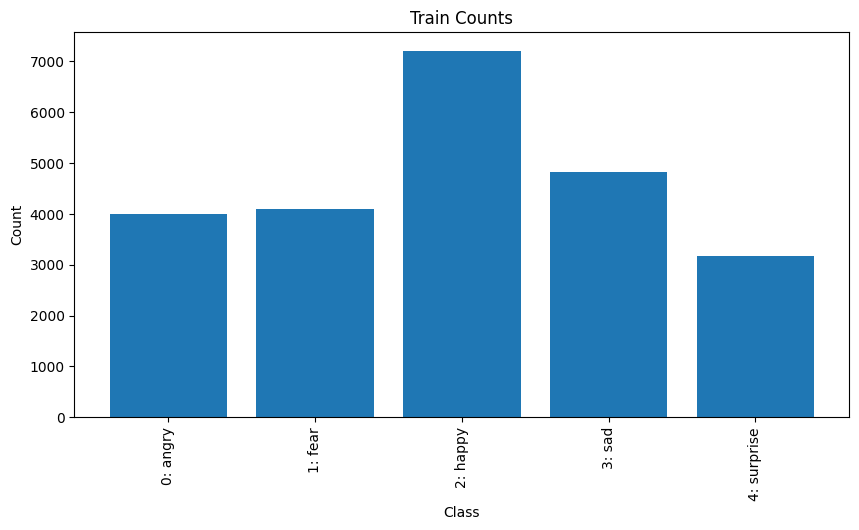

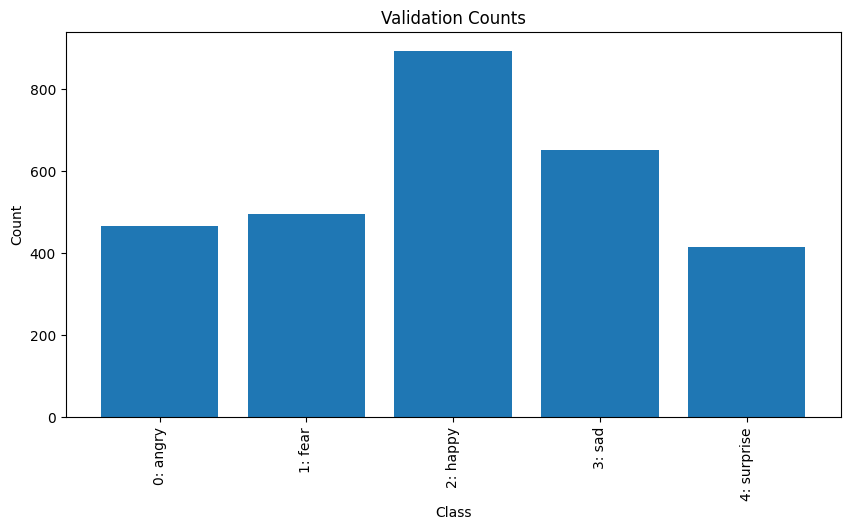

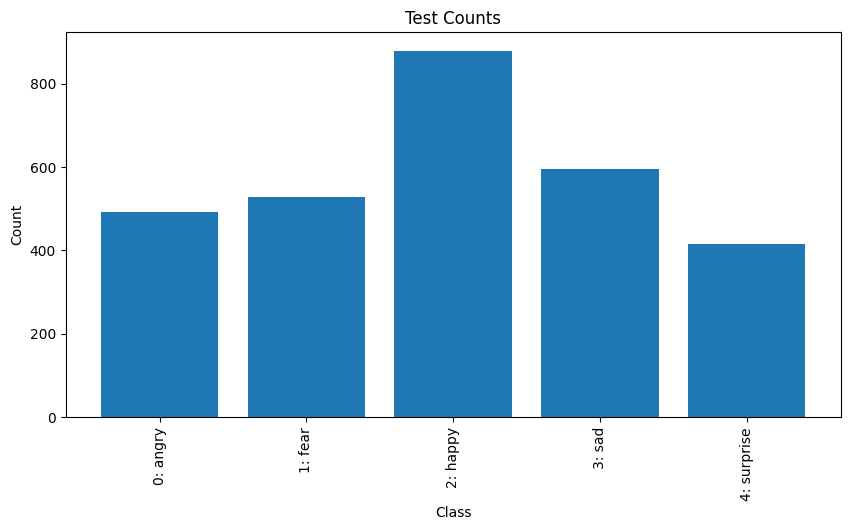

In [25]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Count labels in the original dataset for train
original_counts = Counter(train_data.targets)

# Count labels in the subsets
valid_counts = Counter(test_data.dataset.targets[i] for i in valid_indices)
test_counts = Counter(test_data.dataset.targets[i] for i in test_indices)

# Plot
plot_class_distribution(original_counts, 'Train Counts')
plot_class_distribution(valid_counts, 'Validation Counts')
plot_class_distribution(test_counts, 'Test Counts')

####Data seems to be imbalanced with happy class having a lot more data, remaining classes seem to be somewhat equal

### Visualize some sample from the training set before training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


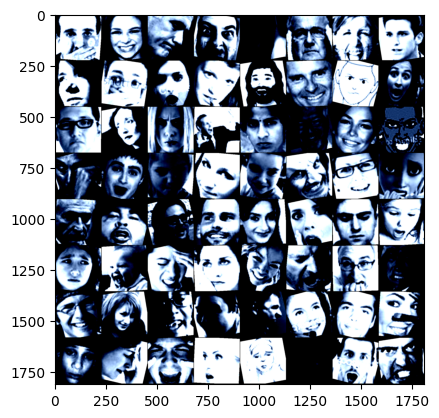

In [26]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Import ResNet50 model and freeze layers + replace classifier to match our number of classes and some basic fc layers with ReLU and end with a softmax activation

In [29]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=5):
        super(ModifiedResNet50, self).__init__()
        # Load a pre-trained ResNet50
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer of the ResNet50 model
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # Remove the original fully connected layer

        # Add new layers according to the described architecture
        self.new_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, num_classes)  # Outputs raw scores (logits)
        )


    def forward(self, x):
        # Extract features using the base model
        x = self.base_model(x)
        # Pass through the new layers
        x = self.new_layers(x)
        return x

# Initialize the model
model = ModifiedResNet50(num_classes=5)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if torch.cuda.is_available():
    print("Using GPU")
else:
    print("Using CPU")

# Display the model
print(model)


Using GPU
ModifiedResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

Define loss function, step optimizer, learning rate scheduler

In [30]:
# Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer - Optimizing parameters of the new layers
optimizer = optim.SGD(model.new_layers.parameters(), lr=0.001, momentum=0.9)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


### Train the model

In [33]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=30)

Epoch 0/29
----------
Train Loss: 1.4105 Acc: 0.4037
Validation Loss: 1.4026 Acc: 0.4105

Epoch 1/29
----------
Train Loss: 1.3474 Acc: 0.4368
Validation Loss: 1.3363 Acc: 0.4357

Epoch 2/29
----------
Train Loss: 1.3173 Acc: 0.4471
Validation Loss: 1.3074 Acc: 0.4494

Epoch 3/29
----------
Train Loss: 1.3002 Acc: 0.4600
Validation Loss: 1.3094 Acc: 0.4525

Epoch 4/29
----------
Train Loss: 1.2946 Acc: 0.4620
Validation Loss: 1.2849 Acc: 0.4675

Epoch 5/29
----------
Train Loss: 1.2860 Acc: 0.4684
Validation Loss: 1.2732 Acc: 0.4747

Epoch 6/29
----------
Train Loss: 1.2751 Acc: 0.4726
Validation Loss: 1.2906 Acc: 0.4569

Epoch 7/29
----------
Train Loss: 1.2696 Acc: 0.4723
Validation Loss: 1.2697 Acc: 0.4716

Epoch 8/29
----------
Train Loss: 1.2700 Acc: 0.4754
Validation Loss: 1.2818 Acc: 0.4641

Epoch 9/29
----------
Train Loss: 1.2616 Acc: 0.4759
Validation Loss: 1.2662 Acc: 0.4761

Epoch 10/29
----------
Train Loss: 1.2554 Acc: 0.4876
Validation Loss: 1.2488 Acc: 0.4908

Epoch 11/

### Plot the loss and accuracy values during training for the train and validation sets

In [1]:
# Plot the history
plot_history(history)

NameError: name 'plot_history' is not defined

### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [ ]:
# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [2]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

NameError: name 'calculate_metrics' is not defined

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)